In [1]:
#%% Setup.

# Activate environment.
# ! . ~/env/bin/activate

# Requirements.

#! pip install --upgrade numpy torch scipy sklearn nibabel nilearn matplotlib

In [2]:
#%% Imports.
import numpy as np
import ardent

import matplotlib
%matplotlib inline
#%matplotlib notebook

# TODO: remove with ardent.io.
from pathlib import Path
import nibabel as nib 

/home/dtward/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#%% Load template and target.

#directory_path = Path('/home/dcrowley/image_lddmm_tensorflow')
directory_path = Path('/home/dtward/Documents/cis/ardent-work/neuronex2/datasets')
atlas_image_filename = 'average_template_50.img'
target_image_filename = '180517_Downsample.img'

atlasPath = directory_path / atlas_image_filename
targetPath = directory_path / target_image_filename

atlas = np.array(nib.load(str(atlasPath)).get_data()).astype(float).squeeze()
target = np.array(nib.load(str(targetPath)).get_data()).astype(float).squeeze()

In [4]:
#%% Downsample
def down2(I):
    nxd = np.array(I.shape)//2
    Id = np.zeros(nxd)
    down = [2,2,2]
    for i in range(down[0]):
        for j in range(down[1]):
            for k in range(down[2]):
                Id += I[i:down[0]*nxd[0]:down[0],
                        j:down[1]*nxd[1]:down[1],k:down[2]*nxd[2]:down[2]]/(down[0]*down[1]*down[2])
    return Id
atlas=down2(atlas)
target=down2(target)

In [5]:
#%% Reform and normalize images.

# Normalize.
# Compute mean absolute deviation.
atlas_mean_absolute_deviation = np.mean(np.abs(atlas - np.median(atlas)))
target_mean_absolute_deviation = np.mean(np.abs(target - np.median(target)))

## Pad with zeros.
atlas = np.pad(atlas, pad_width=1, mode='constant', constant_values=0)
#target = np.pad(target, pad_width=1, mode='constant', constant_values=0)


# Subtract mean.
atlas -= np.mean(atlas)
target -= np.mean(target)
# Divide by mean absolute deviation.
atlas /= atlas_mean_absolute_deviation
target /= target_mean_absolute_deviation



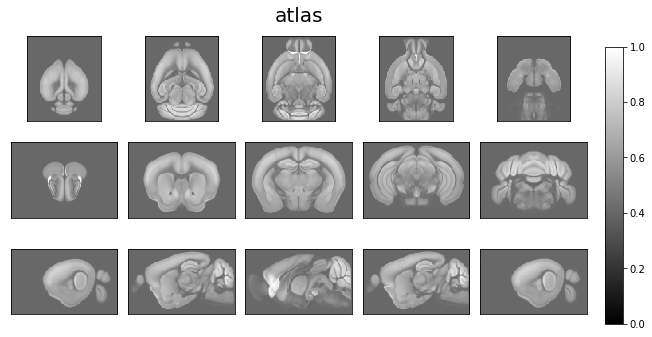

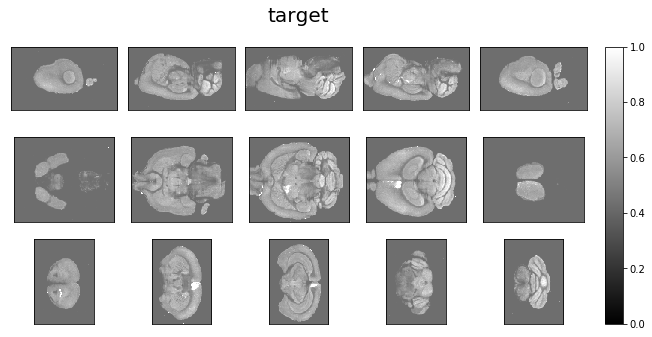

In [6]:
#%% Visualize images before registration.
# It is important to check that the images are oriented to one another 
# and do not require rotating or flipping.

ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(target, title='target', limit_mode='stdev')

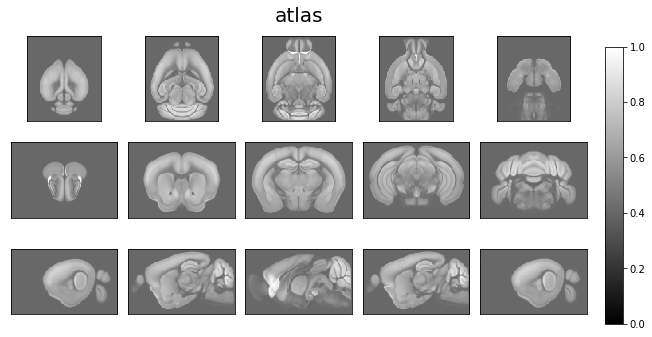

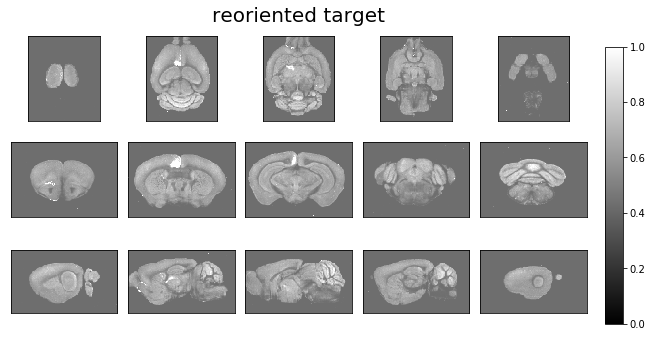

In [7]:
#%% Orient images.
# From looking at the two images we can see that they are not oriented.
# This must be corrected for prior to performing the registration.

# Here we will orient the target to the template (atlas).
reoriented_target = np.copy(target)
reoriented_target = np.rot90(reoriented_target, axes=(1,2))
reoriented_target = np.rot90(reoriented_target, axes=(2,0))
# np.moveaxis does nothing when destination == source.
# reoriented_target = np.moveaxis(reoriented_target, source=[0,1,2], destination=[0,1,2])
reoriented_target = np.flip(reoriented_target, axis=0)
reoriented_target = np.flip(reoriented_target, axis=1)

# If we performed an odd number of inversions with the above line, 
# we must perform a flip to correct for inverting the image. 
# The simplest flip is a sagittal flip, since that is the axis of innate symmetry in the brain.
# In this case, we can see from the atlas visualization that this is axis 2 (the last row).
# The above line performed 2 inversions, so the following line is commented out.
# reoriented_target = np.flip(reoriented_target, axis=2)

# Verify proper orientation.
ardent.heatslices(atlas, title='atlas', limit_mode='stdev')
ardent.heatslices(reoriented_target, title='reoriented target', limit_mode='stdev')

In [8]:
#%% Use reoriented target.
# Once we've finished orienting target, we use the result as target.
# A copy is taken to get a real array rather than a view.
target = reoriented_target.copy()

## Pad images to same shape.
#atlas, target = ardent.lddmm.torch_lddmm_wrapper._pad_to_same_shape(atlas, target)

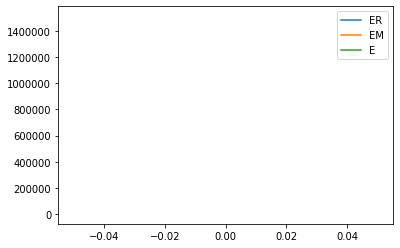

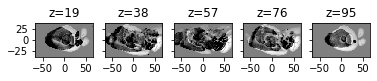

Completed iteration 0, E=1513490.043368437, EM=1513490.043368437, ER=0.0
Completed iteration 1, E=1434018.3594111535, EM=1434018.3301838362, ER=0.029227317208391227
Completed iteration 2, E=1361686.7090316815, EM=1361686.6007166817, ER=0.10831499985388925
Completed iteration 3, E=1296402.1244057156, EM=1296401.8973902897, ER=0.22701542602292546
Completed iteration 4, E=1233650.6749522267, EM=1233650.2980946023, ER=0.37685762430503666


In [9]:
#%% Perform registration.

# Instantiate Transform object.
transform = ardent.Transform()
transform.register(template=atlas, target=target, 
                   sigmaR=1e3, sigmaA=None, 
                   eV=1e0, eT=1e-5, eL=1e-8, 
                   niter=5, draw=True)

In [10]:
#%% Apply the transformation.
# The transformation is the result of the registration, and it can be applied to arbitrary images, 
# although presently they should be preprocessed as the atlas and target were.
# Here we will simply apply the transformation to both the atlas and target, 
# making them match up with each other.
# i.e. deformed_target should resemble atlas, and deformed_atlas should resemble target.

deformed_atlas = transform.apply_transform(subject=atlas, deform_to='target', save_path=None)
deformed_target = transform.apply_transform(subject=target, deform_to='template', save_path=None)
resampled_atlas = transform.apply_transform(subject=atlas, deform_to='target-identity', save_path=None)

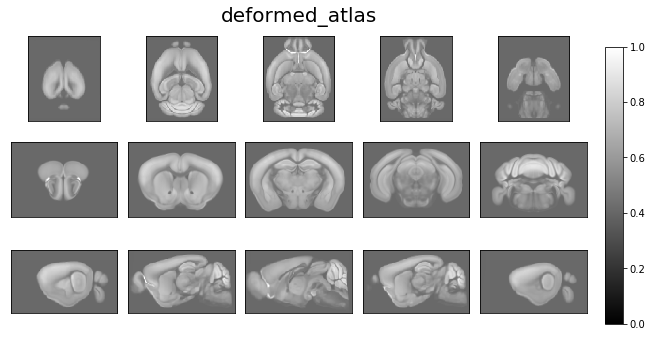

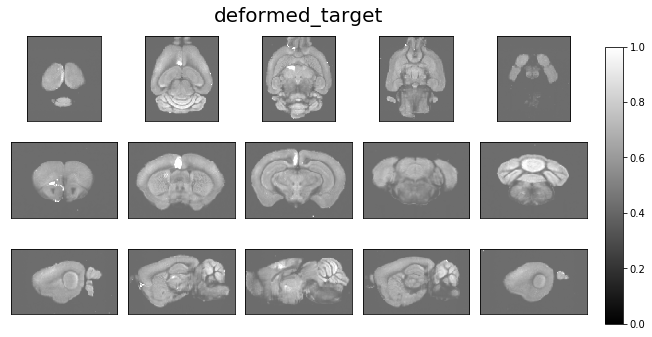

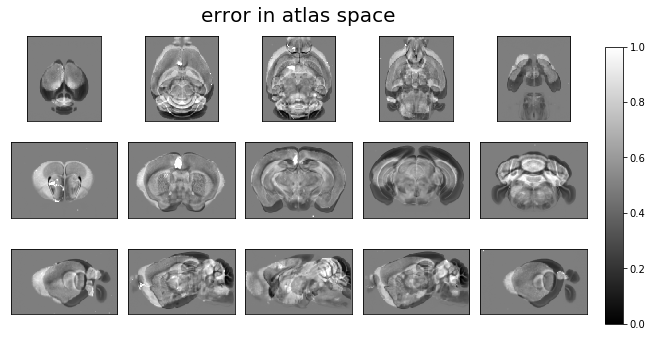

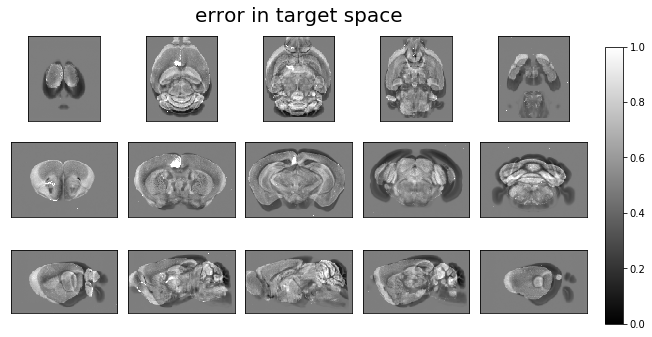

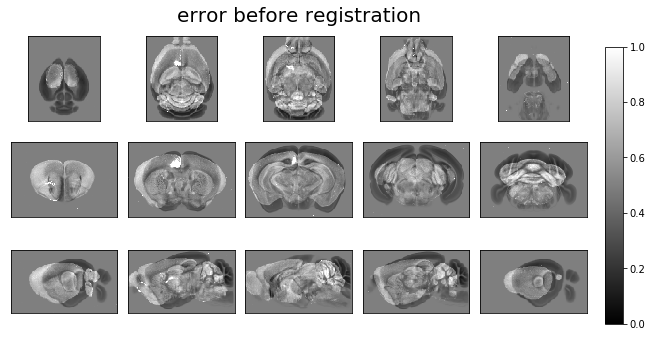

In [11]:
#%% Visualize results.

ardent.heatslices(deformed_atlas, title='deformed_atlas', limit_mode='stdev')
ardent.heatslices(deformed_target, title='deformed_target', limit_mode='stdev')

# To simply visualize error we plot the difference between images.
ardent.heatslices(deformed_target - atlas, title='error in atlas space', limit_mode='stdev')
ardent.heatslices(target - deformed_atlas, title='error in target space', limit_mode='stdev')
ardent.heatslices(target - resampled_atlas, title='error before registration', limit_mode='stdev') # this needs to be changed